In [1]:
import os

import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.gae.optimizer import optimizerAE, optimizerVAE,get_roc_score,accuracy
from gae.gae.model import GCNModelAE, GCNModelVAE
import gae.gae.model
from gae.gae.preprocessing import preprocess_graph, sparse_to_tuple, mask_test_edges,sparse_mx_to_torch_sparse_tensor
import gae.gae.preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


In [2]:
name='f3000_varFeatures_knn10_connectivity_seed3'
adj_path=os.path.join('/nfs','latdata','xinyi','slideseq','xamatrices','a','f3000_knn10_connectivity.npz')
features_path=os.path.join('/nfs','latdata','xinyi','slideseq','xamatrices','x','f3000_XvarFeatures.npz')
# Load data
adj_orig=sp.load_npz(adj_path)
features=sp.load_npz(features_path)
features=sparse_mx_to_torch_sparse_tensor(features)

hidden1=32 #Number of units in hidden layer 1
hidden2=16 #Number of units in hidden layer 2
dropout=0
model_str='gcn_vae'

num_nodes,num_features = features.shape
if model_str == 'gcn_ae':
    model = gae.gae.model.GCNModelAE(num_features, hidden1, hidden2, dropout)
elif model_str == 'gcn_vae':
    model  = gae.gae.model.GCNModelVAE(num_features, hidden1, hidden2, dropout)
elif model_str=='gcn_vae3':
    model  = gae.gae.model.GCNModelVAE3(num_features, hidden1, hidden2,hidden3, dropout)
model.load_state_dict(torch.load('gae/models/'+name+'.pt'))
## get embedding of full adjacency matrix
model.eval()
adj_norm_full = gae.gae.preprocessing.preprocess_graph(adj_orig)
adj_recon,mu,logvar = model(features, adj_norm_full)


In [ ]:
np.random.seed(3)
reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(mu.detach().numpy())

In [3]:
f3000_celltype=pd.read_csv('/nfs/latdata/xinyi/slideseq/seuratresults/slideseq3000feature/predicted_id.csv')
labels_true=f3000_celltype.V1

Estimated number of clusters: 8
Estimated number of noise points: 25894
Homogeneity: 0.120
Completeness: 0.098
V-measure: 0.108
Adjusted Rand Index: -0.020
Adjusted Mutual Information: 0.107


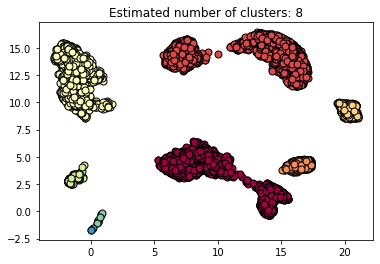

In [25]:
# X = StandardScaler().fit_transform(mu.detach().numpy())
X=mu.detach().numpy()
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=50).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = umap_embedding[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=7)

#     xy = umap_embedding[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [39]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: -0.028


In [7]:
f3000_coord=pd.read_csv('/nfs/latdata/xinyi/slideseq/seuratresults/slideseq3000feature/coordinates.csv')

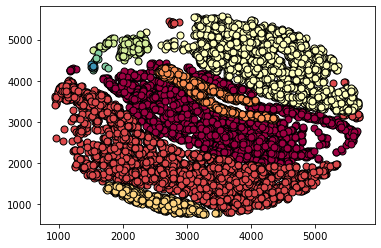

In [26]:
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = f3000_coord[class_member_mask & core_samples_mask]
    plt.plot(xy.x, xy.y, 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=7)
    
#     xy = f3000_coord[class_member_mask & ~core_samples_mask]
#     plt.plot(xy.x, xy.y, 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

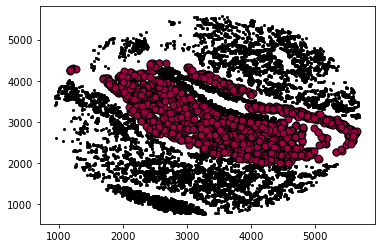

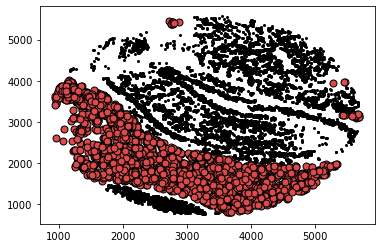

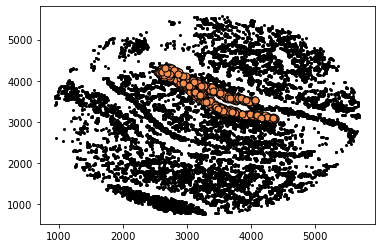

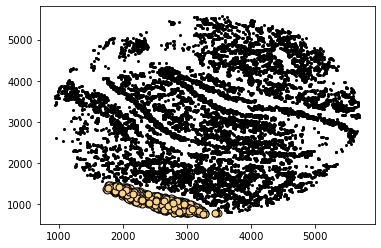

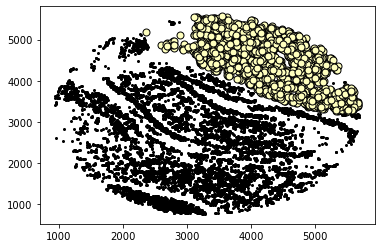

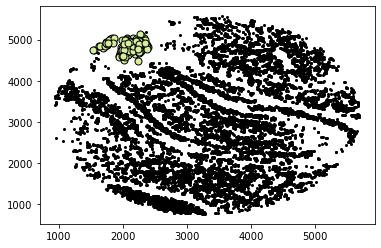

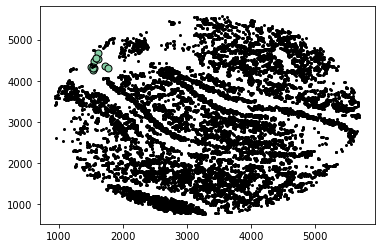

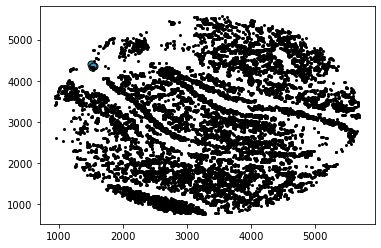

In [55]:
for k, col in zip(unique_labels, colors):
    if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]
        continue

    class_member_mask = (labels == k)

    xy = f3000_coord[class_member_mask & core_samples_mask]
    plt.plot(xy.x, xy.y, 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=7)
    
    col=[0,0,0,1]
    xy = f3000_coord[~class_member_mask & core_samples_mask]
    plt.plot(xy.x, xy.y, 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)
    plt.show()

array(['Unassigned', 'CA3 Principal cells', 'Oligodendrocyte',
       'Astrocyte', 'Ependymal', 'CA1 Principal cells',
       'Entorhinal cortex', 'Interneuron', 'Dentate Principal cells',
       'Endothelial tip', 'Dentate hilum', 'Polydendrocyte-1',
       'Endothelial stalk', 'Polydendrocyte-2', 'Neurogenesis (SGZ)',
       'Subiculum', 'Mural', 'Microglia', 'Resident macrophage'],
      dtype=object)

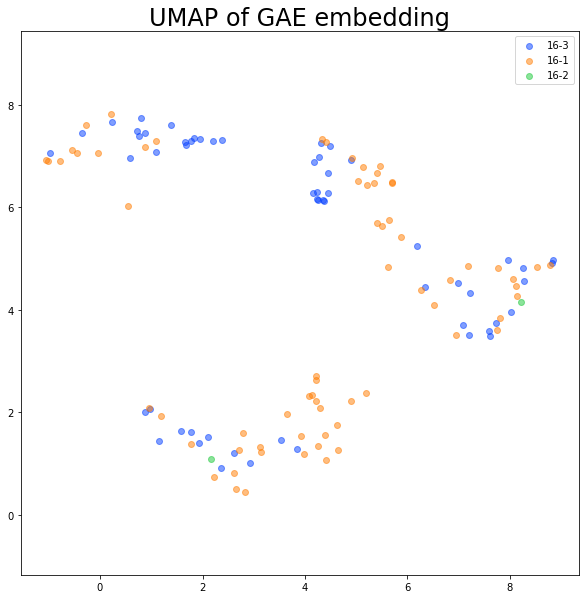

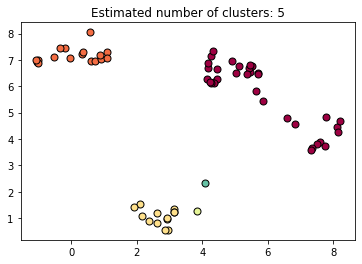

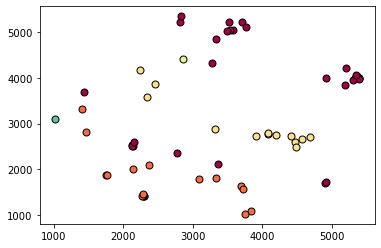

In [37]:
np.random.seed(3)
f3000_subcluster=pd.read_csv('/nfs/latdata/xinyi/slideseq/seuratresults/slideseq3000feature/predicted_id_subcluster.csv')
celltypes=f3000_celltype.V1.unique()
if not os.path.exists('gae/plots/'+name+'/subclusters_assignedonly'):
    os.makedirs('gae/plots/'+name+'/subclusters_assignedonly')
    
colortest=sns.color_palette("bright")
colortest.extend(sns.color_palette("dark"))

# for ct in celltypes:
for ct in ['Mural']:
    if ct == 'Unassigned':
        continue
        
    idx=f3000_celltype['V1']==ct
    emb_ct=mu.detach().numpy()
    emb_ct=emb_ct[idx,]
    
    reducer = umap.UMAP()
    umap_embedding_ct = reducer.fit_transform(emb_ct)
    

    fig, ax = plt.subplots()
    cidx=0
    for subct in f3000_subcluster.V1[idx].unique():
        if subct == 'Unassigned':
            continue
        idx_sub=f3000_subcluster['V1']==subct
        idx_sub=idx_sub[idx]
        ax.scatter(
            umap_embedding_ct[idx_sub, 0],
            umap_embedding_ct[idx_sub, 1],
            color=colortest[cidx],label=subct,alpha=0.5
            )
        cidx+=1

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.legend()
    plt.title('UMAP of GAE embedding', fontsize=24)
    plt.savefig('gae/plots/'+name+'/subclusters_assignedonly/seed3_umapCT_bysubcluster_'+ct+'.jpg')
    plt.show()
    
    db = DBSCAN(eps=0.6, min_samples=5).fit(emb_ct)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = umap_embedding_ct[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=7)

    #     xy = umap_embedding[class_member_mask & ~core_samples_mask]
    #     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #              markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.savefig('gae/plots/'+name+'/subclusters_assignedonly/seed3_umapCT_bysubcluster_'+ct+'_dbscan_eps06_min_samples5.jpg')
    plt.show()
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = f3000_coord.to_numpy()[idx,]
        xy=xy[class_member_mask & core_samples_mask]
        plt.plot(xy[:,1], xy[:,2], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=7)
    plt.savefig('gae/plots/'+name+'/subclusters_assignedonly/seed3_umapCT_bysubcluster_'+ct+'_dbscan_location_eps06_min_samples5.jpg')
    plt.show()